In [1]:
from datetime import datetime

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from dataset import CustomDataset

In [2]:
N = 100
k = 50
Nt = N+k # liczba punktów, w których liczymy liczebność populacji
tmax = 60 # do jakiego czasu liczymy 
t = np.linspace(0,tmax, Nt)

In [3]:
class LVPredictorNetwork(nn.Module):
    def __init__(self):
        super(LVPredictorNetwork, self).__init__()
        
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2 * N, N + k, bias=False).double(),
            nn.ReLU(),
            nn.Linear(N + k, N + k, bias=False).double(),
            nn.ReLU(),
            nn.Linear(N + k, 2 * k, bias=False).double(),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x.to('cpu'))
        return logits

In [4]:

training_data = CustomDataset("dane_treningowe.csv", N, k)
test_data = CustomDataset("dane_treningowe_100.csv", N, k)

train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

model = LVPredictorNetwork()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [5]:
def train_one_epoch(epoch_index, tb_writer, batch_num=1000):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting

    for i, data in enumerate(train_dataloader):
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % batch_num == batch_num - 1:
            last_loss = running_loss / batch_num  # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_data) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [6]:

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 20

best_validation_loss = 1_000_000.

EPOCH 1:


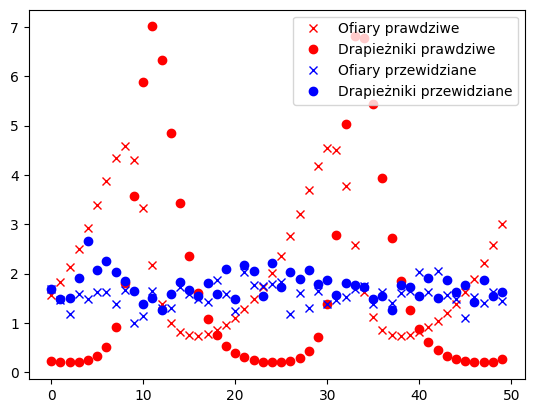

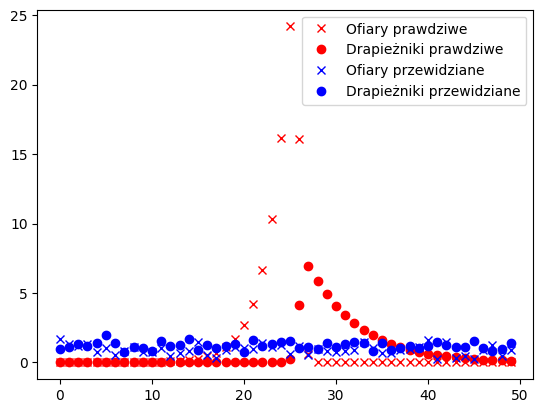

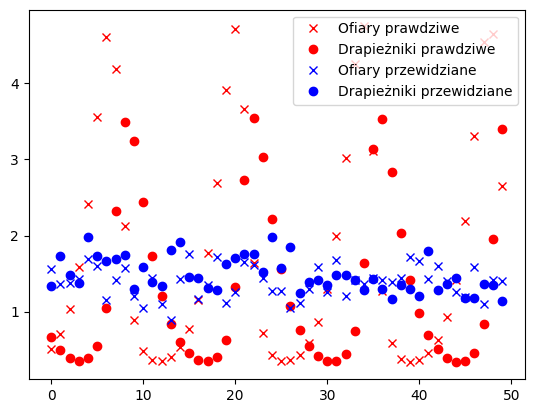

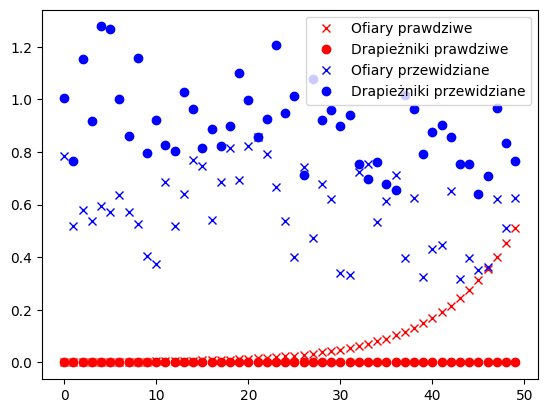

tensor(5.7606, dtype=torch.float64, grad_fn=<DivBackward0>)
EPOCH 2:


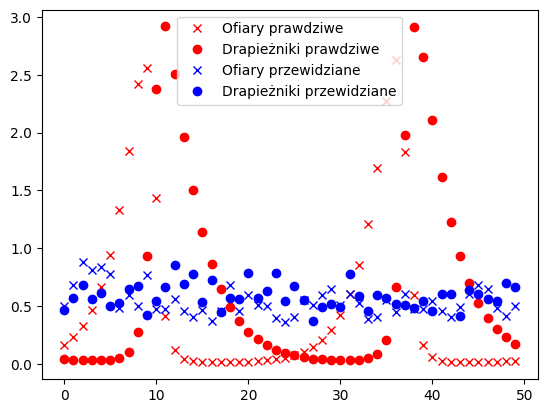

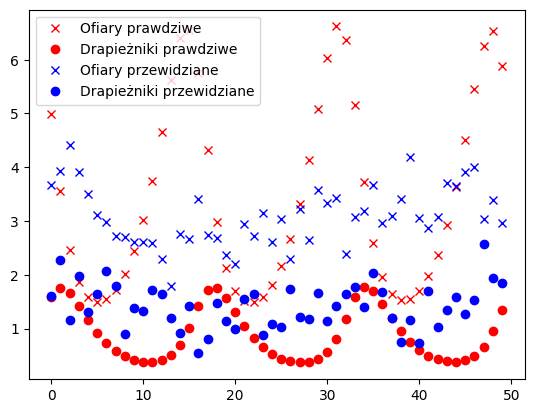

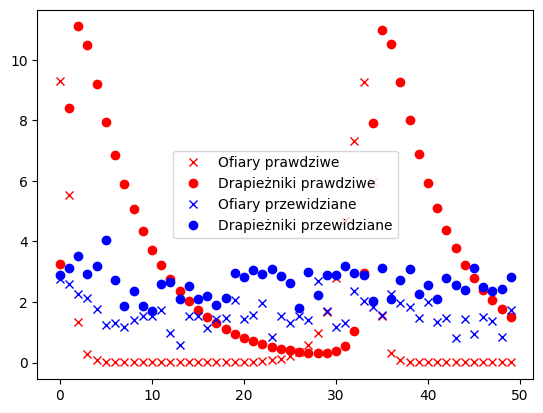

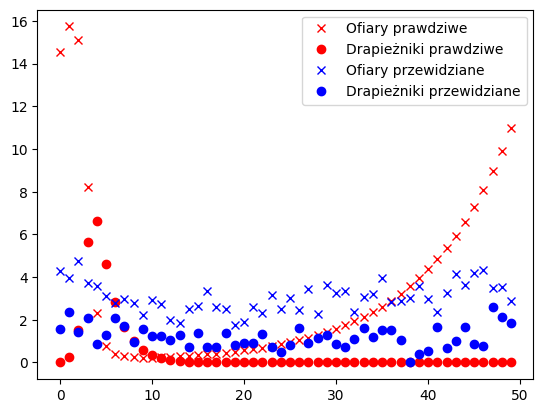

tensor(6.8417, dtype=torch.float64, grad_fn=<DivBackward0>)
EPOCH 3:


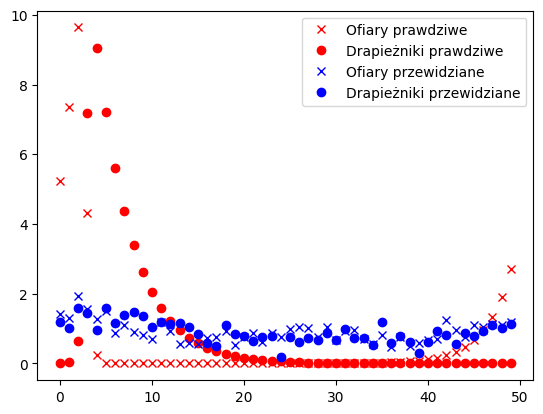

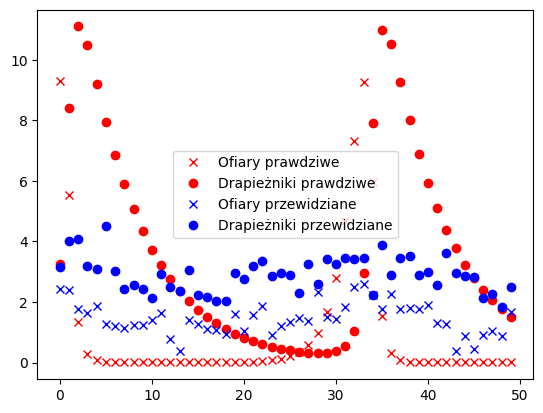

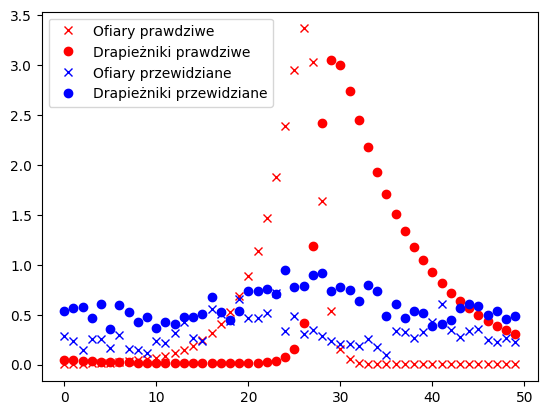

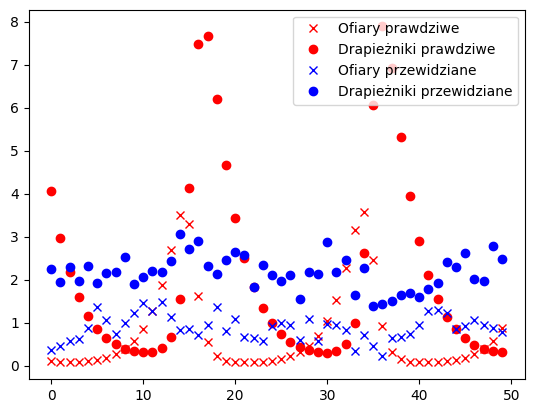

tensor(6.2467, dtype=torch.float64, grad_fn=<DivBackward0>)
EPOCH 4:


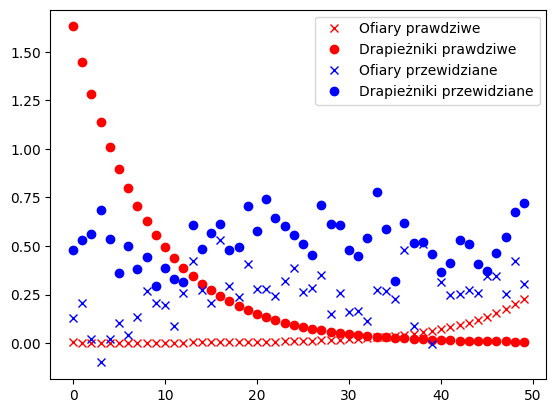

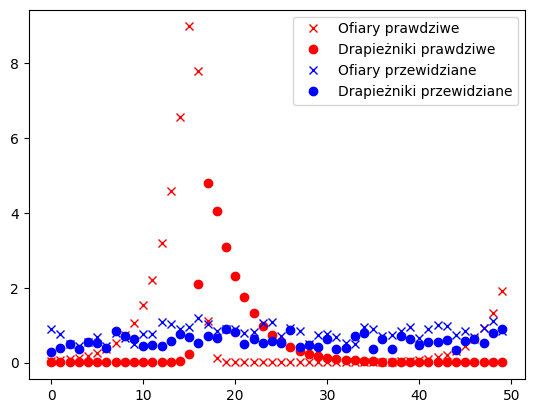

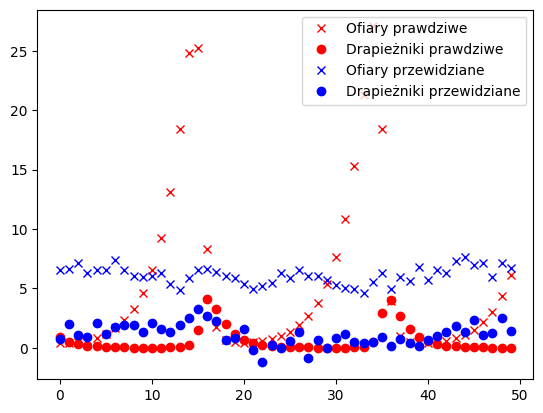

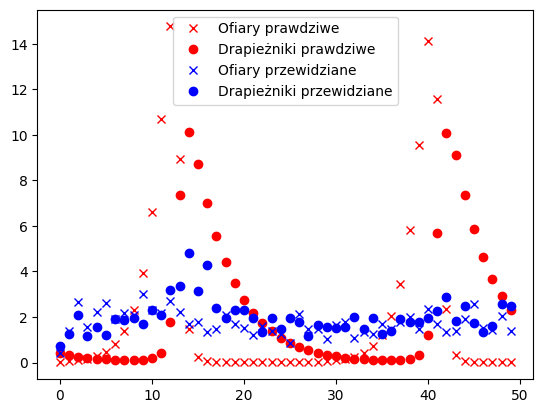

tensor(5.1786, dtype=torch.float64, grad_fn=<DivBackward0>)
EPOCH 5:


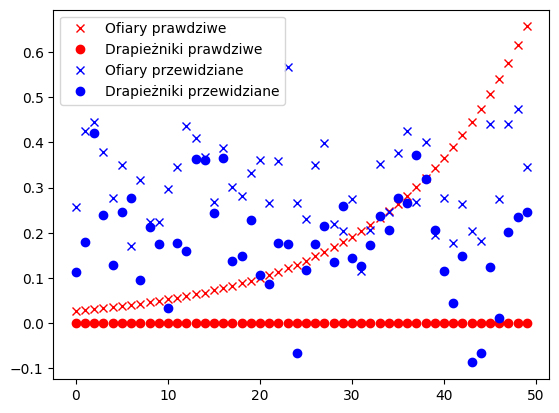

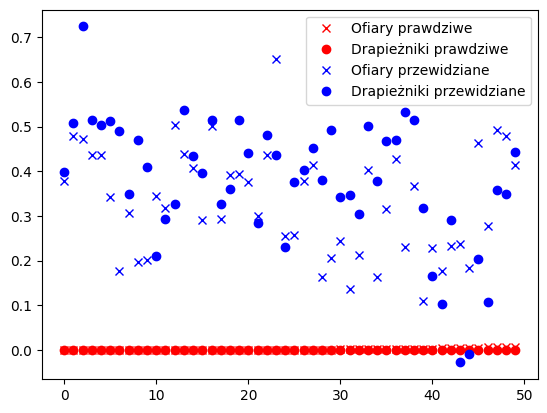

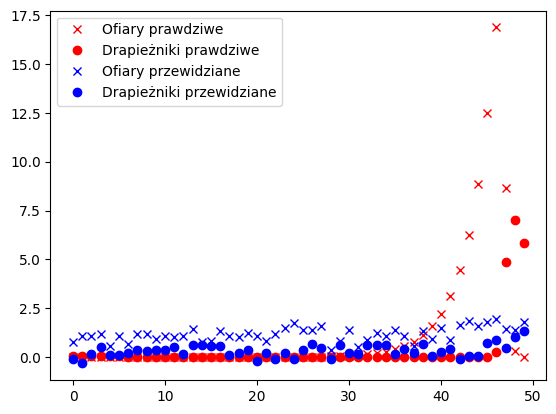

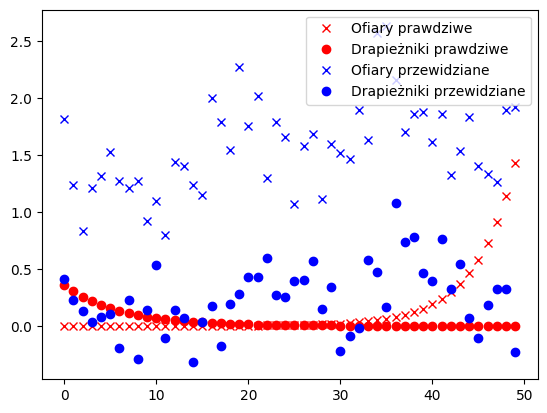

tensor(5.0668, dtype=torch.float64, grad_fn=<DivBackward0>)
EPOCH 6:


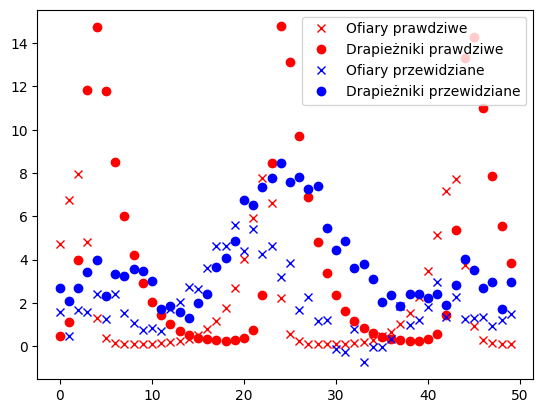

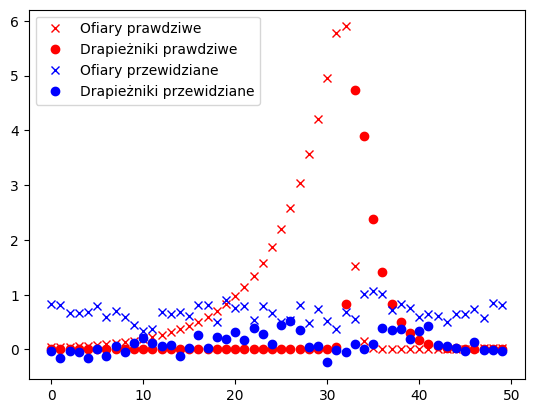

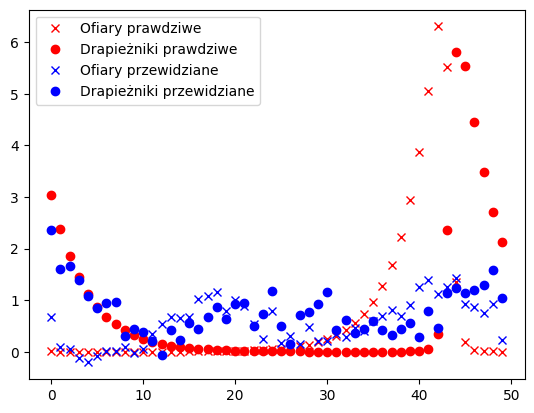

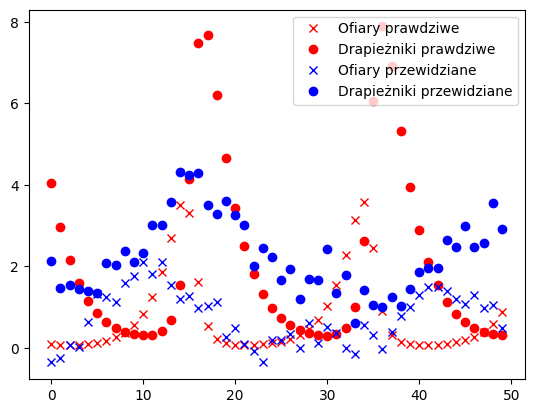

tensor(4.6024, dtype=torch.float64, grad_fn=<DivBackward0>)
EPOCH 7:


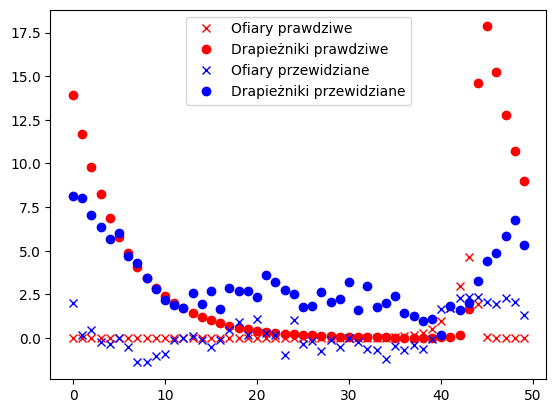

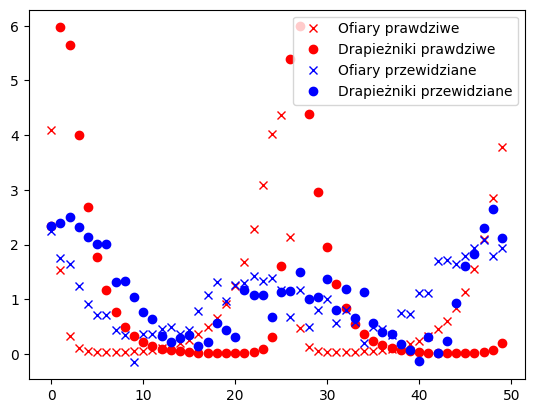

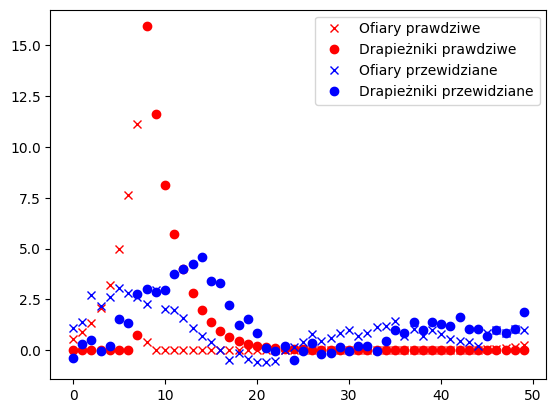

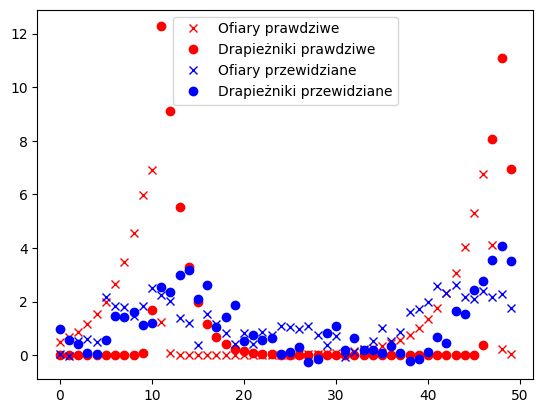

tensor(4.3252, dtype=torch.float64, grad_fn=<DivBackward0>)
EPOCH 8:


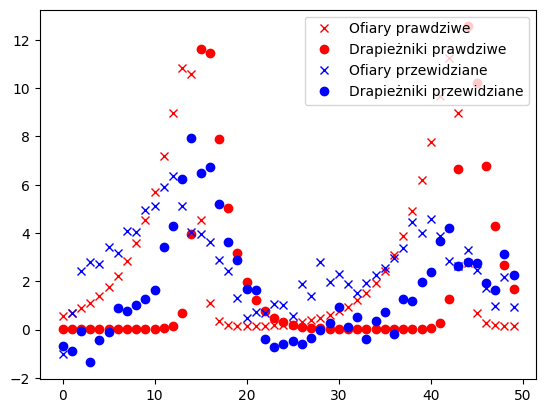

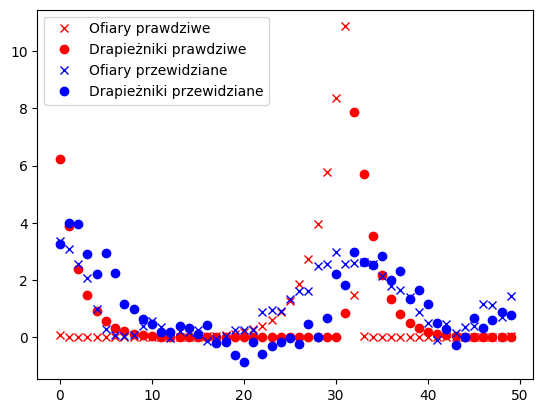

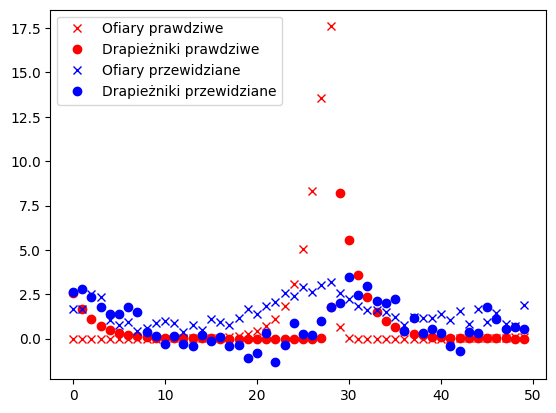

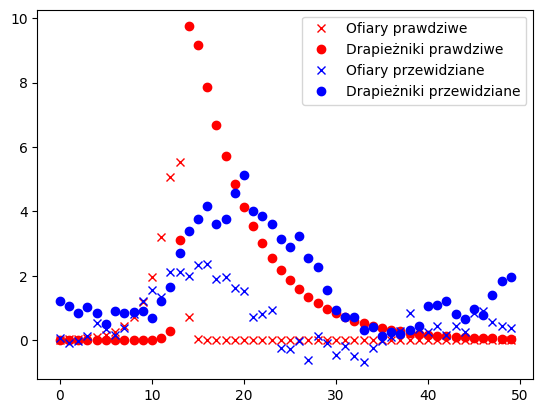

tensor(4.6685, dtype=torch.float64, grad_fn=<DivBackward0>)
EPOCH 9:


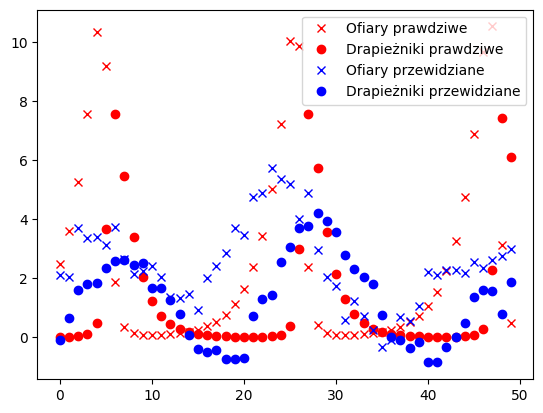

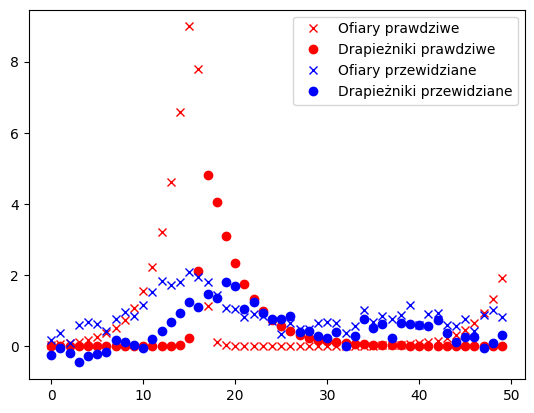

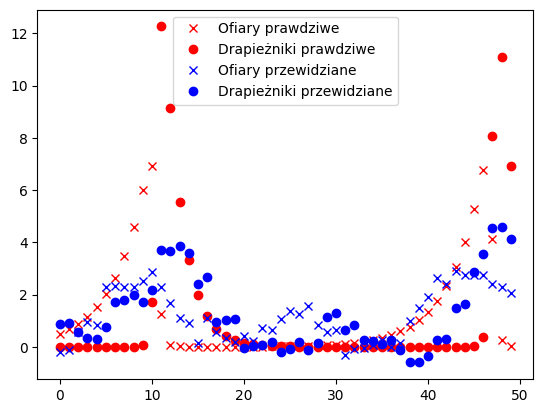

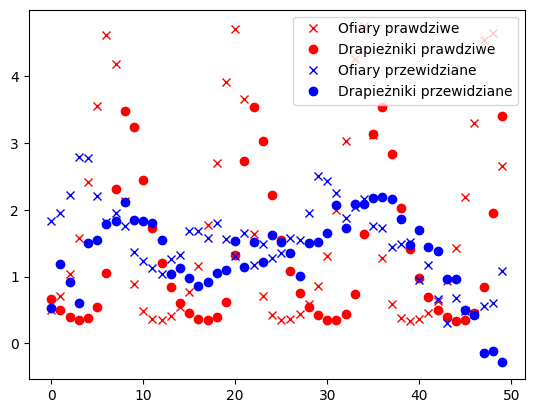

tensor(3.8427, dtype=torch.float64, grad_fn=<DivBackward0>)
EPOCH 10:


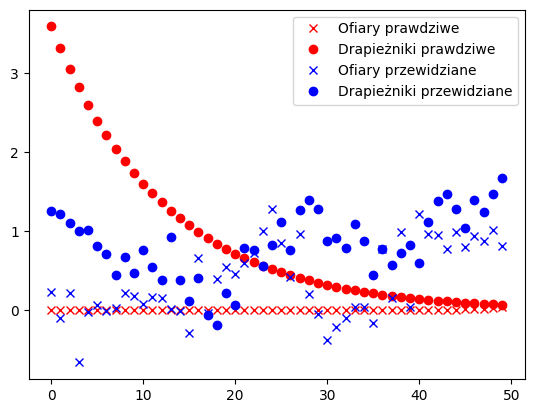

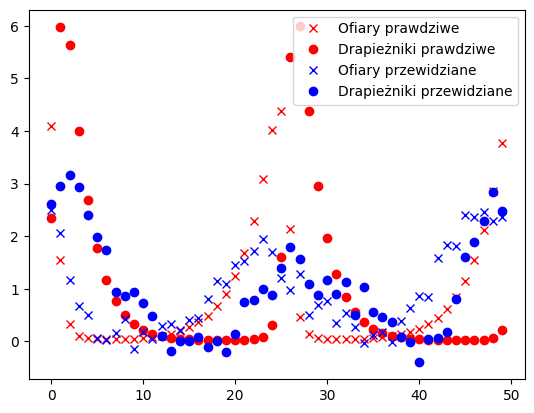

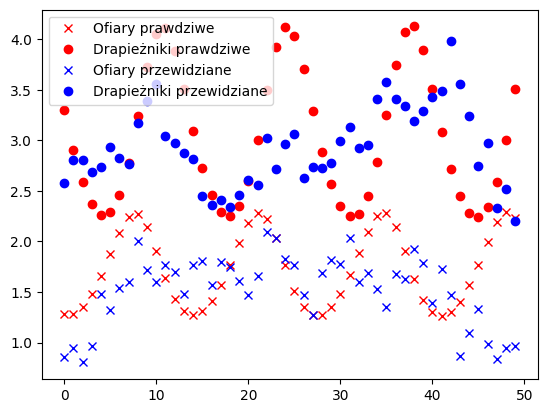

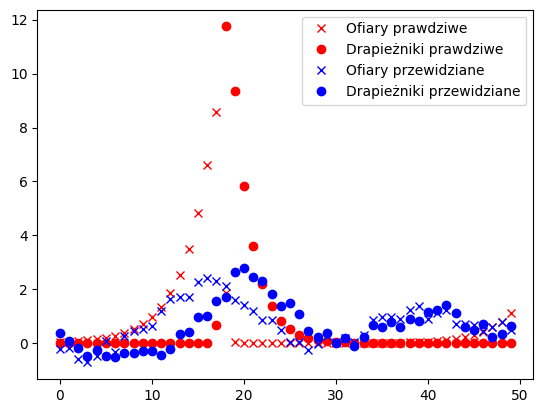

tensor(4.4333, dtype=torch.float64, grad_fn=<DivBackward0>)
EPOCH 11:


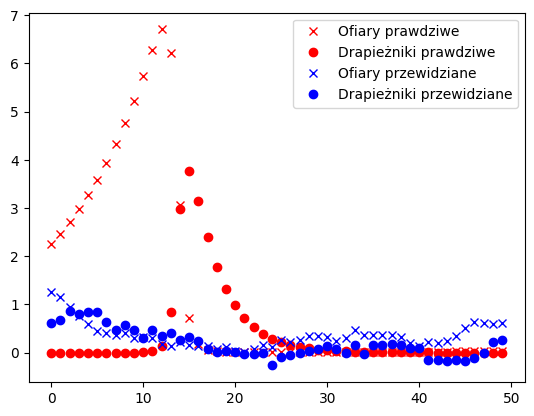

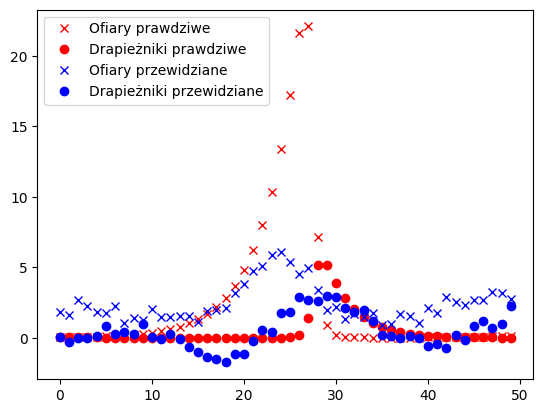

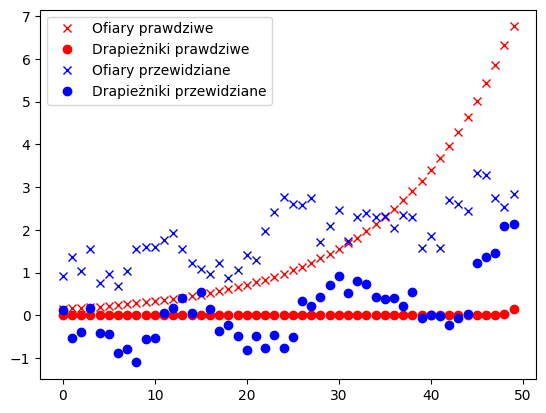

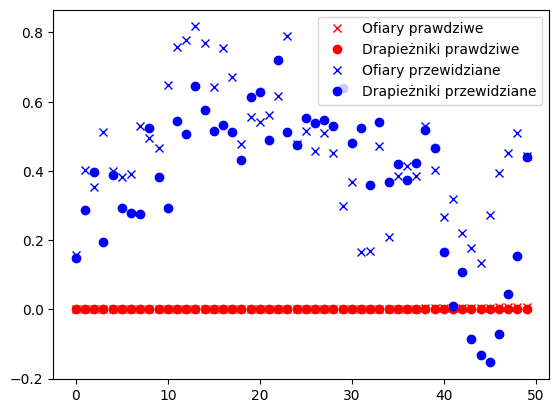

tensor(3.8702, dtype=torch.float64, grad_fn=<DivBackward0>)
EPOCH 12:


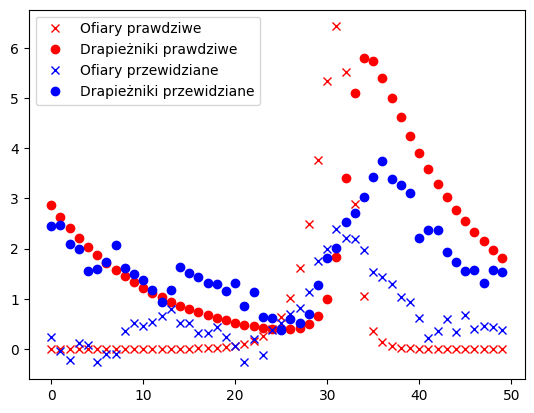

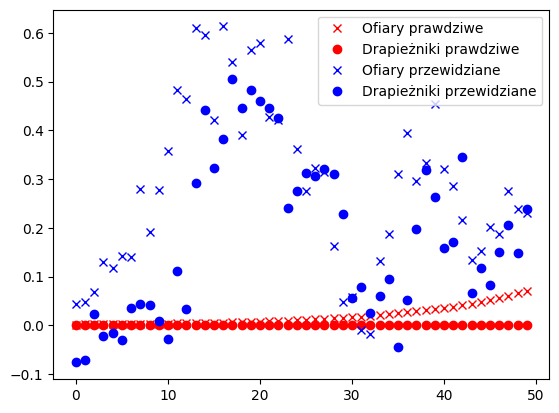

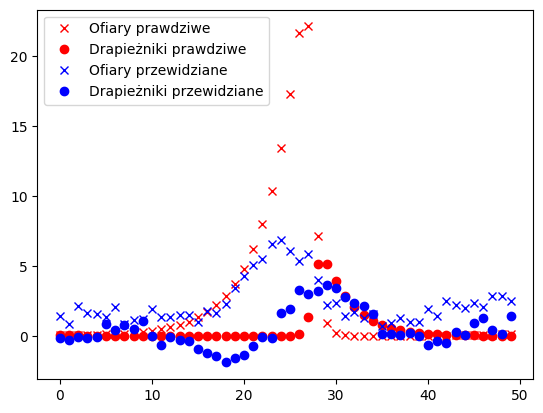

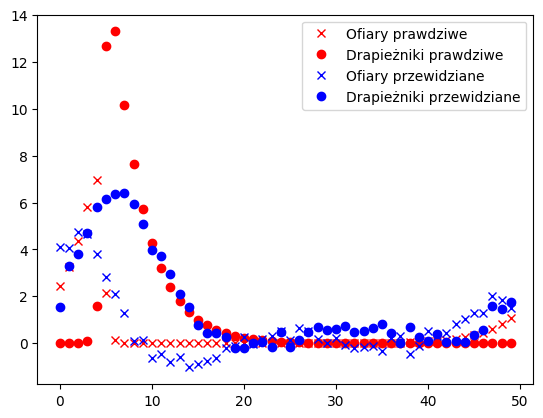

tensor(3.2899, dtype=torch.float64, grad_fn=<DivBackward0>)
EPOCH 13:


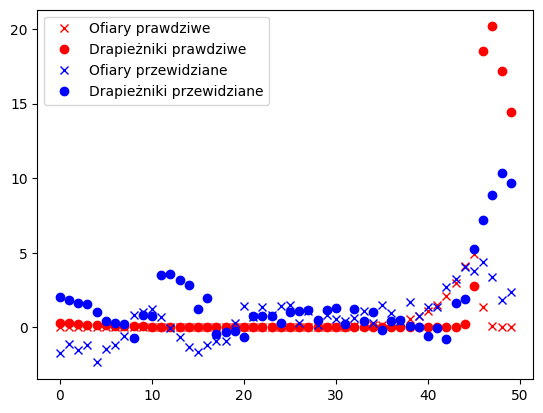

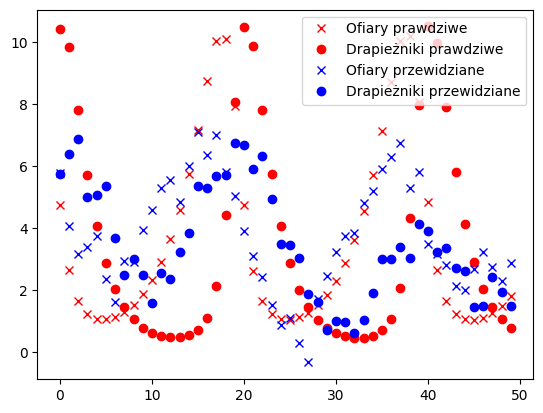

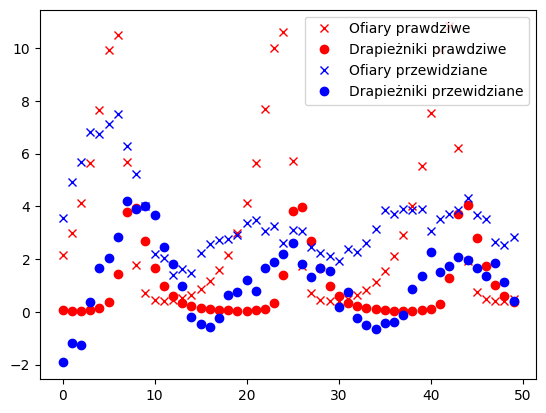

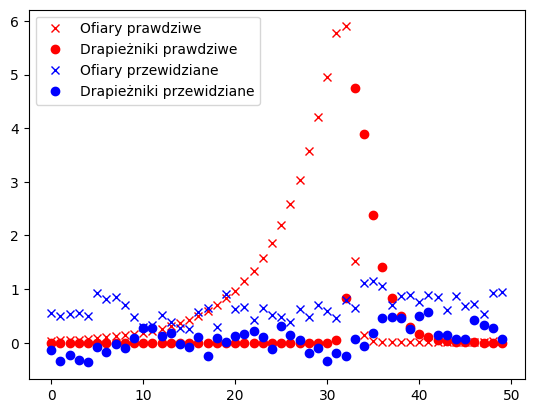

tensor(3.2832, dtype=torch.float64, grad_fn=<DivBackward0>)
EPOCH 14:


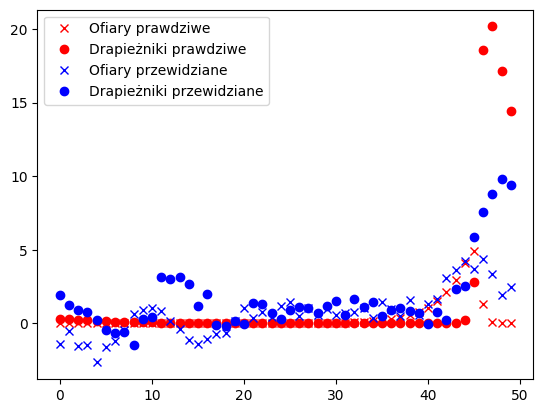

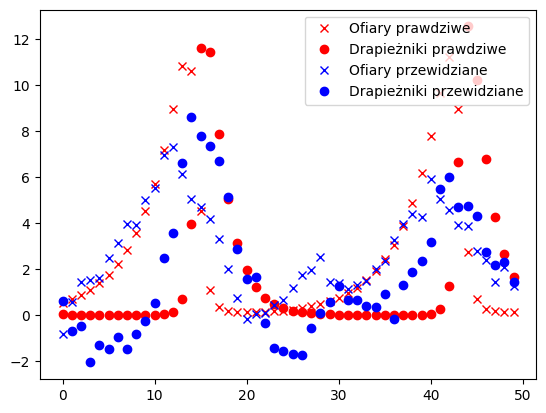

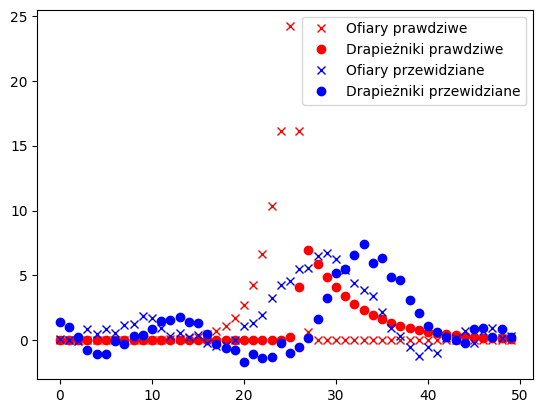

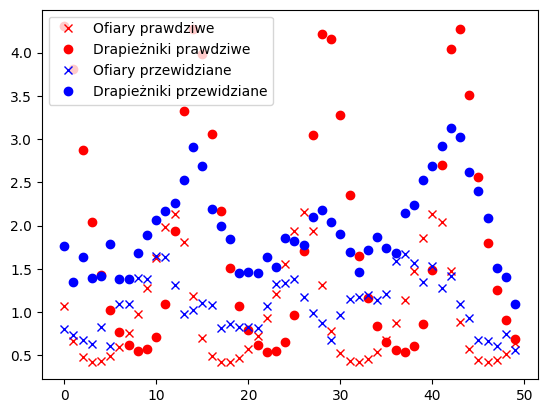

tensor(3.9836, dtype=torch.float64, grad_fn=<DivBackward0>)
EPOCH 15:


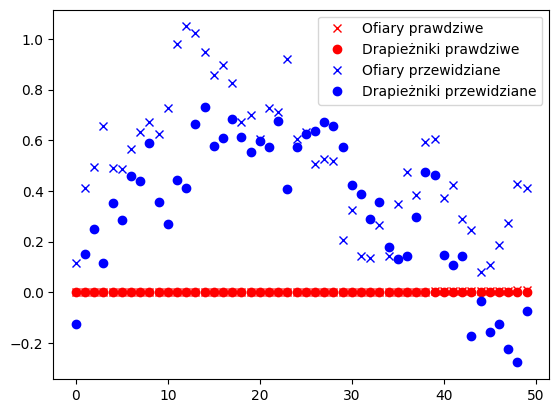

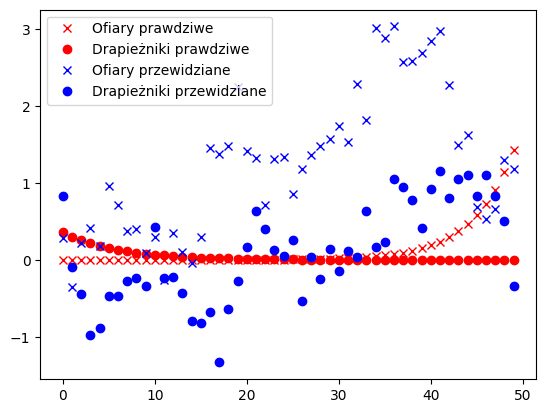

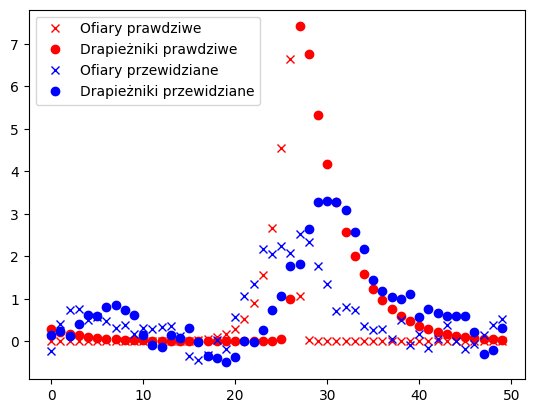

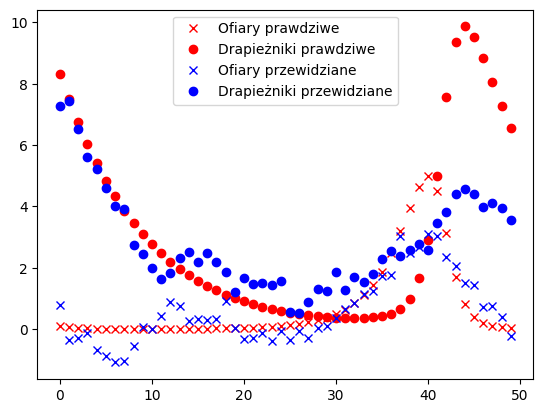

tensor(3.6899, dtype=torch.float64, grad_fn=<DivBackward0>)
EPOCH 16:


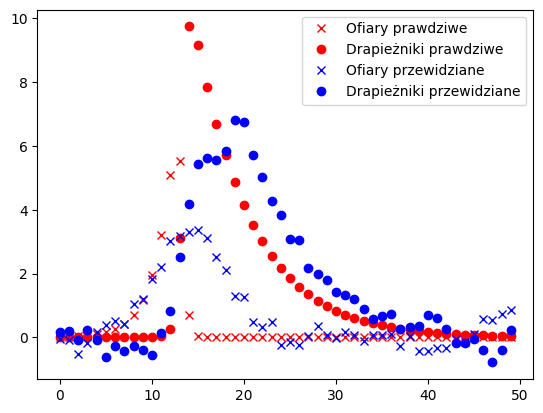

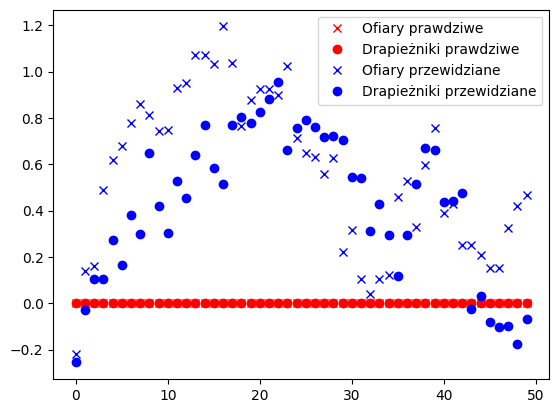

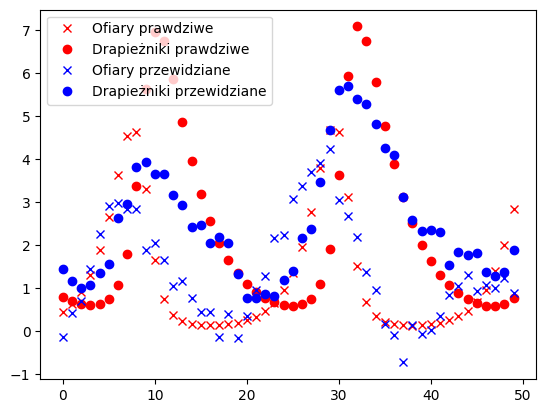

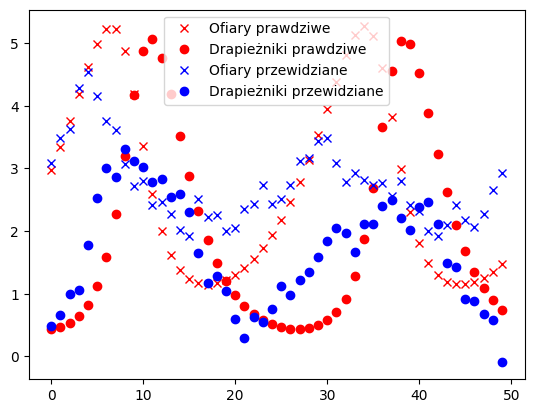

tensor(2.9130, dtype=torch.float64, grad_fn=<DivBackward0>)
EPOCH 17:


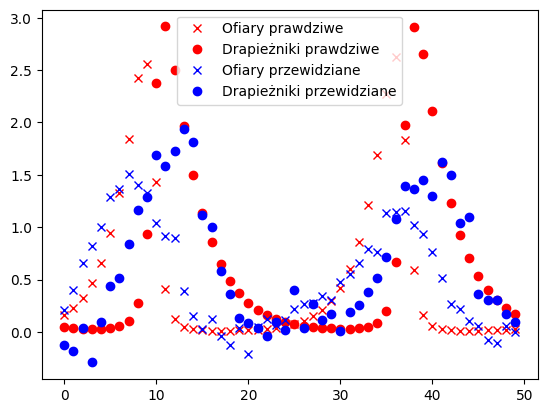

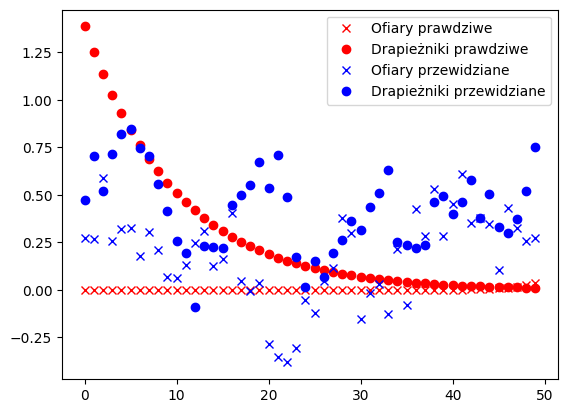

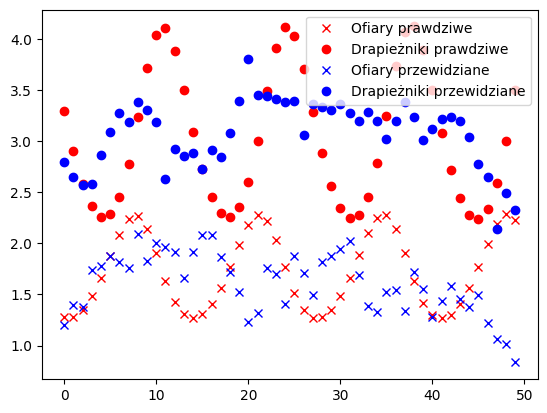

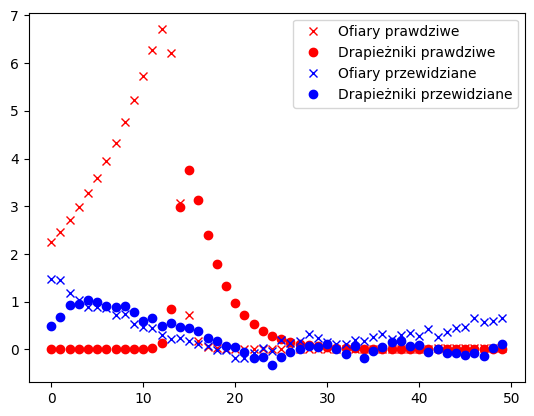

tensor(3.2387, dtype=torch.float64, grad_fn=<DivBackward0>)
EPOCH 18:


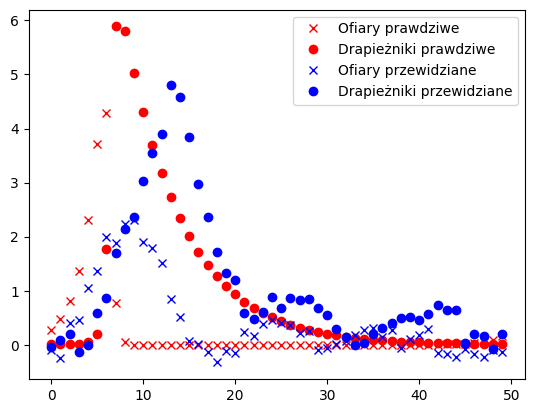

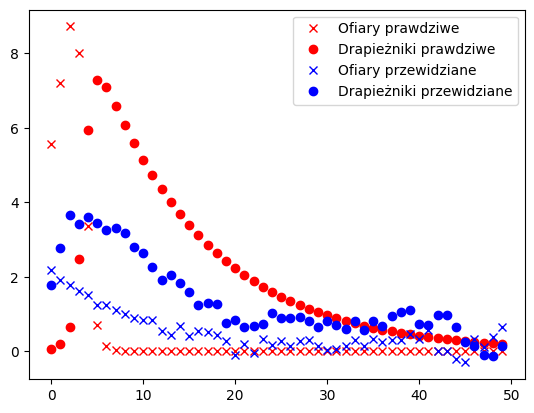

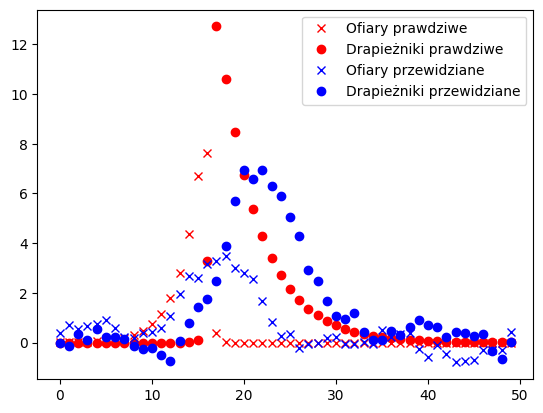

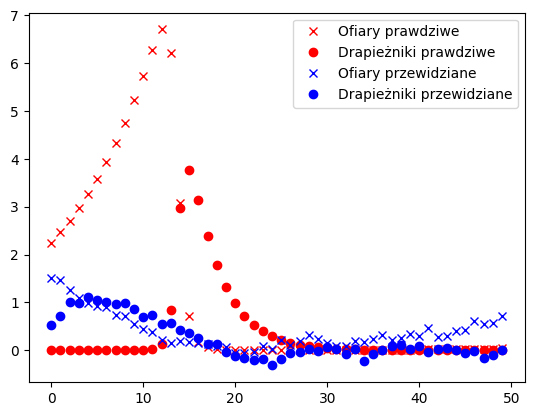

tensor(3.4396, dtype=torch.float64, grad_fn=<DivBackward0>)
EPOCH 19:


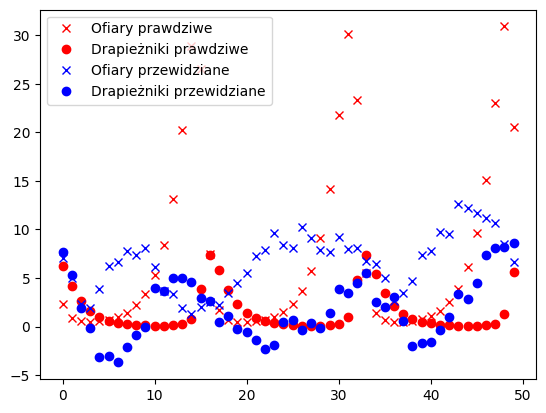

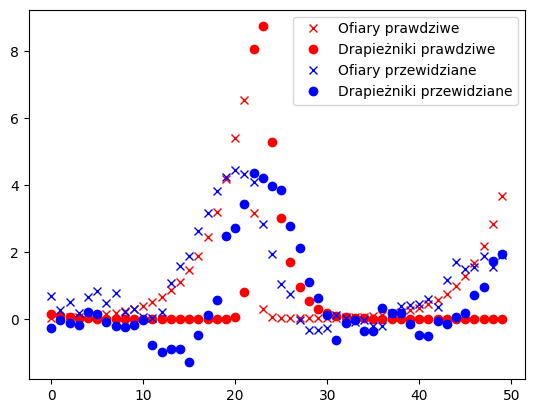

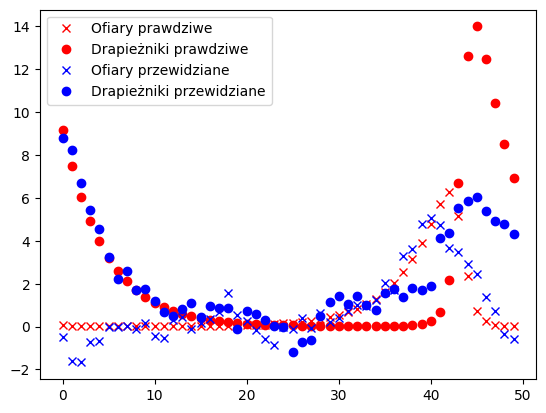

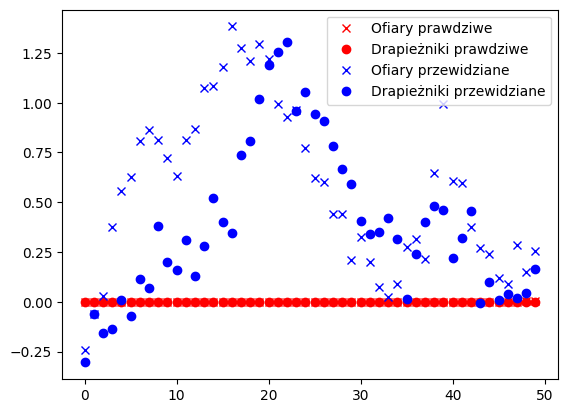

tensor(2.7801, dtype=torch.float64, grad_fn=<DivBackward0>)
EPOCH 20:


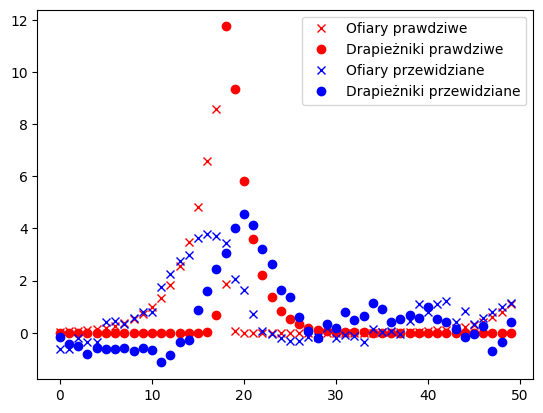

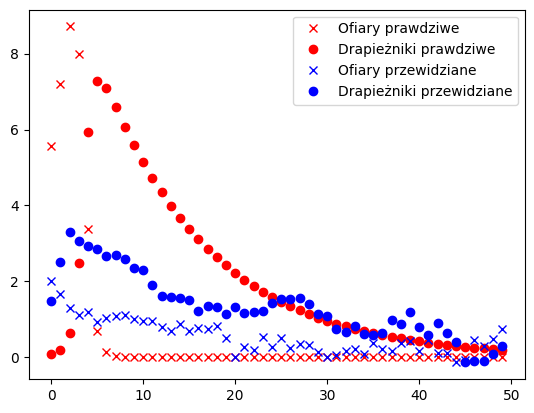

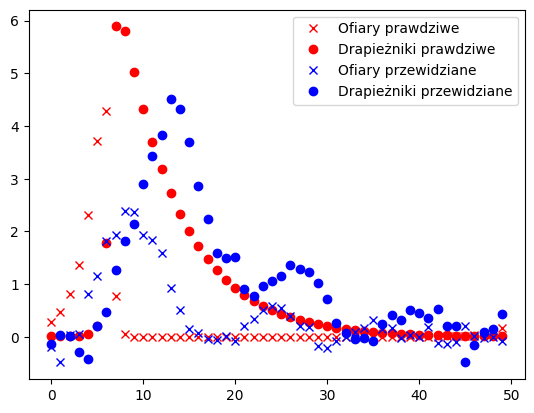

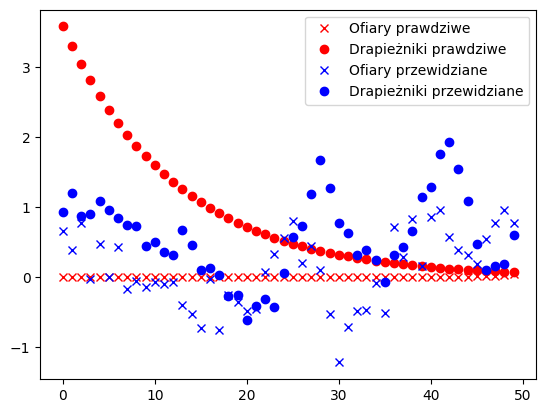

tensor(2.9199, dtype=torch.float64, grad_fn=<DivBackward0>)


In [7]:
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_validation_loss = 0.0
    for i, validation_data in enumerate(test_dataloader):
        validation_inputs, validation_labels = validation_data
        validation_outputs = model(validation_inputs)
        validation_loss = loss_fn(validation_outputs, validation_labels)
        running_validation_loss += validation_loss
        # plt.figure()
        # plt.grid()
        
        prawdziwe = validation_labels.detach().numpy()[0]
        przewidziane = validation_outputs.detach().numpy()[0]
        prawdziwe = np.reshape(prawdziwe, (2, k), order = 'F')
        przewidziane = np.reshape(przewidziane, (2, k), order = 'F')
        x_0, y_0 = prawdziwe
        x_1, y_1 = przewidziane
        # plt.plot(validation_inputs.detach().numpy()[0])
        # plt.plot(validation_outputs.detach().numpy()[0])
        
        plt.plot(x_0, 'xr', label = 'Ofiary prawdziwe')
        plt.plot(y_0, 'or', label = 'Drapieżniki prawdziwe')
        plt.plot(x_1, 'xb', label = 'Ofiary przewidziane')
        plt.plot(y_1, 'ob', label = 'Drapieżniki przewidziane')
        
        # print(type(validation_labels.detach().numpy()[0]))
        # print(validation_labels.detach().numpy()[0])
        # print(prawdziwe.shape)
        # print(przewidziane.shape)
        # plt.title("odeint")
        # tensor.detach().numpy()
        # plt.xlabel('Czas t, [dni]')
        # plt.ylabel('Populacja')
        plt.legend()

        plt.show()

    avg_validation_loss = running_validation_loss / len(test_dataloader)

    # Log the running loss averaged per batch
    # for both training and validation
    print(avg_validation_loss)
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training': avg_loss, 'Validation': avg_validation_loss},
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_validation_loss < best_validation_loss:
        best_validation_loss = avg_validation_loss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1
